In [1]:
import numpy as np
 
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Load Data & Pre-processing

In [2]:
class Make_Dataset(Dataset):
 
  def __init__(self,x_tensor, y_tensor):
    self.x = x_tensor
    self.y = y_tensor
 
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

In [3]:
### Load Data ###

CCesc2i_Meta = pd.read_table('data/CellCycle/CCesc2i_Meta.txt')
CCesc2i_counts = pd.read_table('data/CellCycle/CCesc2i_counts.txt')
CCesc2i_sampleinfo = pd.read_table('data/CellCycle/CCesc2i_sampleinfo.txt')
CCescSerum_Meta = pd.read_table('data/CellCycle/CCescSerum_Meta.txt')
CCescSerum_counts = pd.read_table('data/CellCycle/CCescSerum_counts.txt')
CCescSerum_sampleinfo = pd.read_table('data/CellCycle/CCescSerum_sampleinfo.txt')

DTesc2i_Meta = pd.read_table('data/DrugTreatment/DTesc2i_Meta.txt')
DTesc2i_tpm = pd.read_table('data/DrugTreatment/DTesc2i_tpm.txt')
DTesc2i_sampleinfo = pd.read_table('data/DrugTreatment/DTesc2i_sampleinfo.txt')
DTescSerum_Meta = pd.read_table('data/DrugTreatment/DTescSerum_Meta.txt')
DTescSerum_tpm = pd.read_table('data/DrugTreatment/DTescSerum_tpm.txt')
DTescSerum_sampleinfo = pd.read_table('data/DrugTreatment/DTescSerum_sampleinfo.txt')

### re-arrange count matrix ###

CCesc2i_counts = CCesc2i_counts.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
CCesc2i_counts.columns.name = None
CCescSerum_counts = CCescSerum_counts.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
CCescSerum_counts.columns.name = None
DTesc2i_tpm = DTesc2i_tpm.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
DTesc2i_tpm.columns.name = None
DTescSerum_tpm = DTescSerum_tpm.set_index('Name').T.reset_index().rename(columns = {'index':'Name'})
DTescSerum_tpm.columns.name = None

### Inner Join three tables (Meta data, count matrix, sample info) ###

merged_CCesc2i = pd.merge(left=CCesc2i_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=CCesc2i_counts, left_on='Counts_identifier', right_on='Name')
merged_CCesc2i = pd.merge(left=CCesc2i_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_CCesc2i, left_on='Unnamed: 0', right_on='Counts_identifier')

merged_CCescSerum = pd.merge(left=CCescSerum_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=CCescSerum_counts, left_on='Counts_identifier', right_on='Name')
merged_CCescSerum = pd.merge(left=CCescSerum_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_CCescSerum, left_on='Unnamed: 0', right_on='Counts_identifier')

merged_DTesc2i = pd.merge(left=DTesc2i_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=DTesc2i_tpm, left_on='Counts_identifier', right_on='Name')
merged_DTesc2i = pd.merge(left=DTesc2i_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_DTesc2i, left_on='Unnamed: 0', right_on='Counts_identifier')

merged_DTescSerum = pd.merge(left=DTescSerum_Meta[['Counts_identifier','mVenus_A','mCherry_A','Hoechst_A']], right=DTescSerum_tpm, left_on='Counts_identifier', right_on='Name')
merged_DTescSerum = pd.merge(left=DTescSerum_sampleinfo[['Unnamed: 0','percent_mapped']], right=merged_DTescSerum, left_on='Unnamed: 0', right_on='Counts_identifier')

### process data ###

# Keep only percent_mapped > 40%
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i.percent_mapped <= 40].index)
merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum.percent_mapped <= 40].index)
merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i.percent_mapped <= 40].index)
merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum.percent_mapped <= 40].index)

# Remove cell name "888"
# skip this action because couldn't find any cells contain name of '888'

# Remove cells with negative values in meta data
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i['mVenus_A'] < 0].index)
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i['mCherry_A'] < 0].index)
merged_CCesc2i = merged_CCesc2i.drop(merged_CCesc2i[merged_CCesc2i['Hoechst_A'] < 0].index)

merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum['mVenus_A'] < 0].index)
merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum['mCherry_A'] < 0].index)
merged_CCescSerum = merged_CCescSerum.drop(merged_CCescSerum[merged_CCescSerum['Hoechst_A'] < 0].index)

merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i['mVenus_A'] < 0].index)
merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i['mCherry_A'] < 0].index)
merged_DTesc2i = merged_DTesc2i.drop(merged_DTesc2i[merged_DTesc2i['Hoechst_A'] < 0].index)

merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum['mVenus_A'] < 0].index)
merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum['mCherry_A'] < 0].index)
merged_DTescSerum = merged_DTescSerum.drop(merged_DTescSerum[merged_DTescSerum['Hoechst_A'] < 0].index)

# further process: drop unused columns
CCesc2i = merged_CCesc2i.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})
CCescSerum = merged_CCescSerum.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})
DTesc2i = merged_DTesc2i.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})
DTescSerum = merged_DTescSerum.drop(columns=['percent_mapped', 'Counts_identifier', 'Name']).rename(columns = {'Unnamed: 0':'Name'})

# select UT condition from DT dataset
DTesc2i_UT = DTesc2i[DTesc2i["Name"].str.contains('UT')]
DTescSerum_UT = DTescSerum[DTescSerum["Name"].str.contains('UT')]

# Concat CC + DT_UT Data
CCesc2i_DTesc2i_UT = pd.concat([CCesc2i, DTesc2i_UT])
CCescSerum_DTescSerum_UT = pd.concat([CCescSerum, DTescSerum_UT])

# Concat all conditions
df_total = pd.concat([CCesc2i, CCescSerum, DTesc2i, DTescSerum])

In [4]:
# dataframe to numpy
np_features = CCesc2i_DTesc2i_UT.iloc[:, 4:].values
np_targets = CCesc2i_DTesc2i_UT.iloc[:, 1:4].values

# log normalization
np_features_diff = np_features - np.min(np_features, axis=0)
np_features = np.log(np_features + 0.001)

np_targets = np_targets - np.min(np_targets, axis=0)
np_targets[:, 0] = np.log(np_targets[:, 0] + 0.00001)
np_targets[:, 1] = np.log(np_targets[:, 1] + 0.00001)
np_targets[:, 2] = np.log(np_targets[:, 2] + 0.00001)

# data normalization
np_features = minmax_scaler.fit_transform(np_features)
np_targets = minmax_scaler.fit_transform(np_targets)

# dimensionality reduction by PCA & T-SNE
np_features = PCA(n_components=64).fit_transform(np_features)
#np_features = TSNE(n_components=64, init='random', method='exact').fit_transform(np_features)

# ex: D=50000 -> 500(pca) -> 30(t-sne)

distance_features = np.linalg.norm(np_features - np.mean(np_features, axis=0), axis=1)
distance_targets = np.linalg.norm(np_targets - np.mean(np_targets, axis=0), axis=1)

# remove outliers
index_feature_outliers = distance_features > np.min(distance_features) + 10*np.std(distance_features)
index_target_outliers = distance_targets > np.min(distance_targets) + 4*np.std(distance_targets)
index_outliers = np.logical_or(index_feature_outliers, index_target_outliers)
index = np.logical_not(index_outliers)
np_features = np_features[index]
np_targets = np_targets[index]

print(np.sum(index_feature_outliers))
print(np.sum(index_target_outliers))

cutoff_distance_features = np.linalg.norm(np_features - np.mean(np_features, axis=0), axis=1)
cutoff_distance_targets = np.linalg.norm(np_targets - np.mean(np_targets, axis=0), axis=1)

# data normalization
#np_features = minmax_scaler.fit_transform(np_features)
#np_targets = minmax_scaler.fit_transform(np_targets)

X_train, X_test, y_train, y_test = train_test_split(np_features, np_targets, test_size=0.3, random_state=42)

0
3


In [5]:
def plot_data_distribution(data, title=None):
    plt.figure(figsize=(25, 3))
    if title is not None:
        plt.title(title)
    plt.plot(data, 'o')
    plt.show()

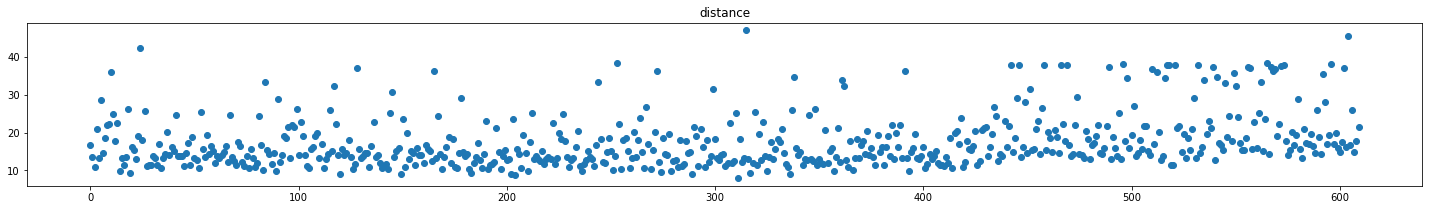

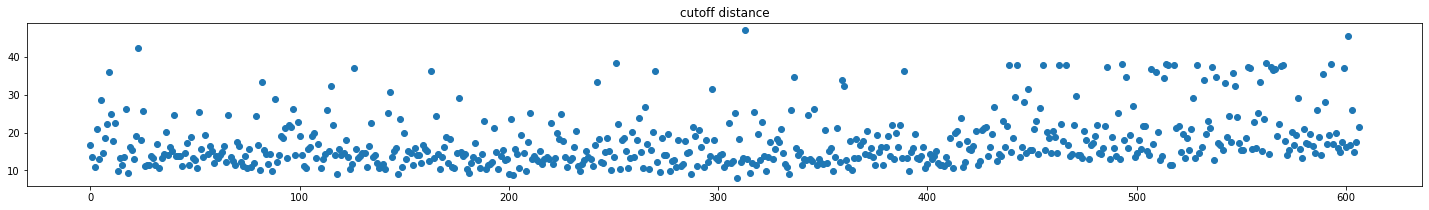

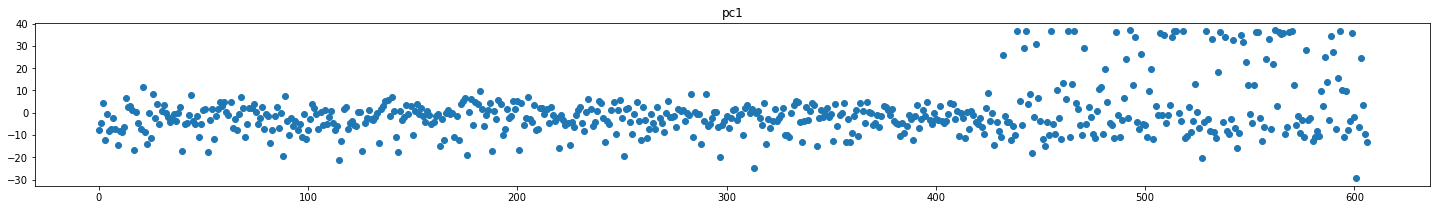

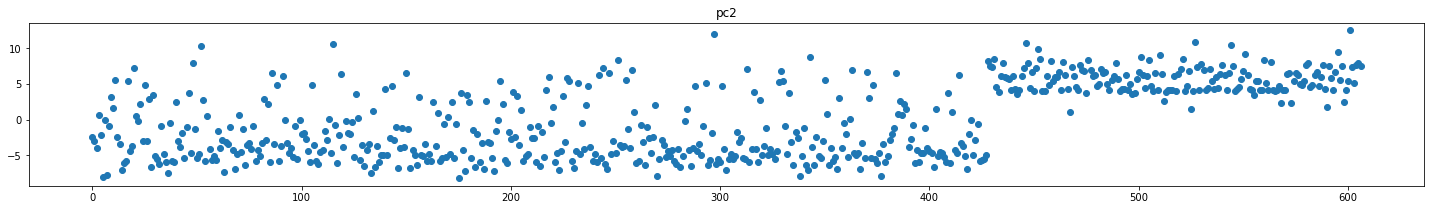

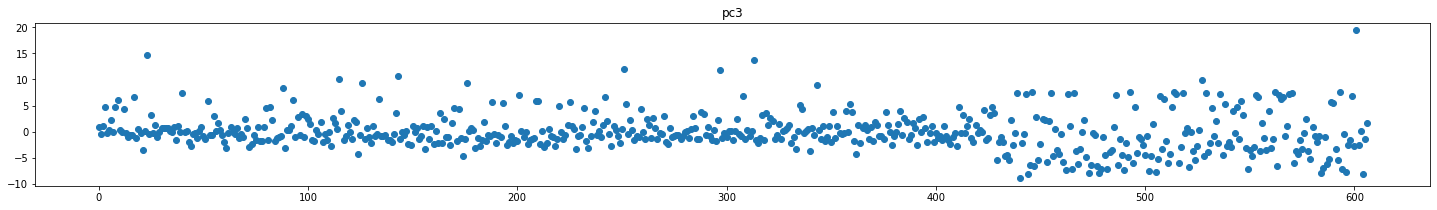

In [6]:
plot_data_distribution(distance_features, title='distance')
plot_data_distribution(cutoff_distance_features, title='cutoff distance')

for i in range(np_features.shape[1] if np_features.shape[1] < 3 else 3):
    plot_data_distribution(np_features[:, i], title='pc{}'.format(i+1))


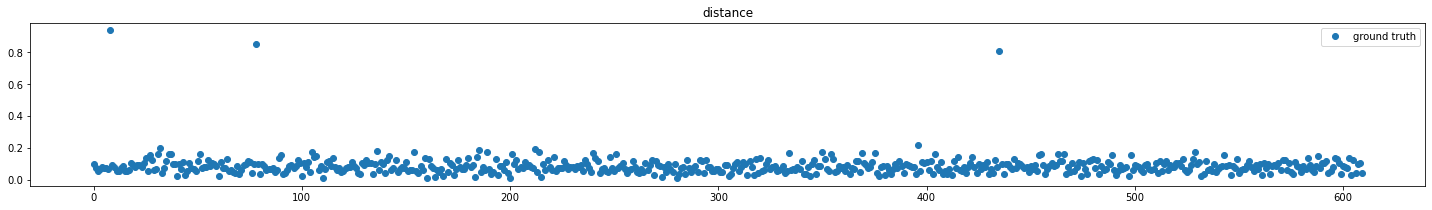

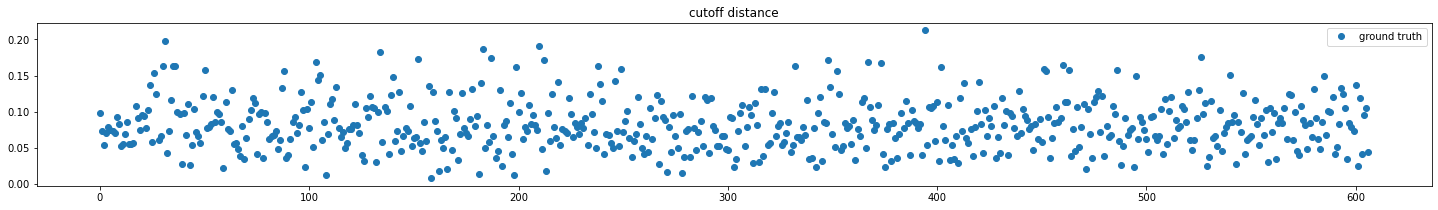

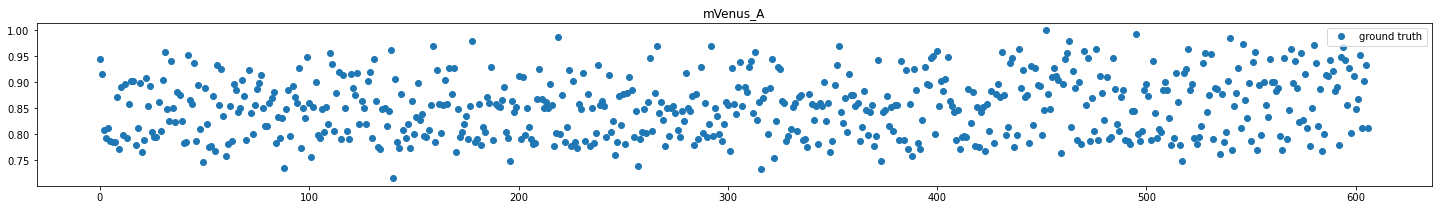

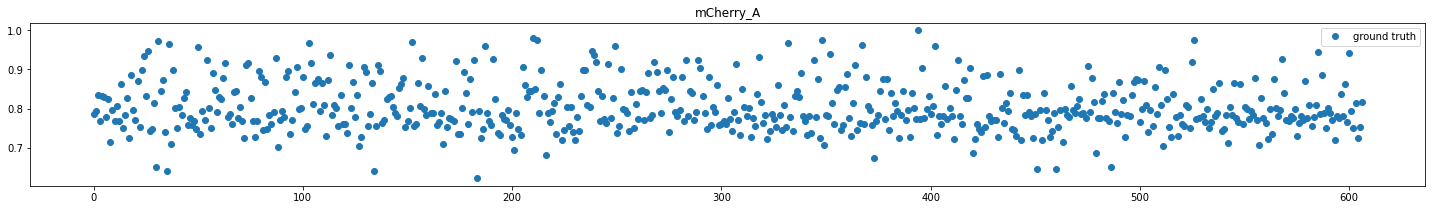

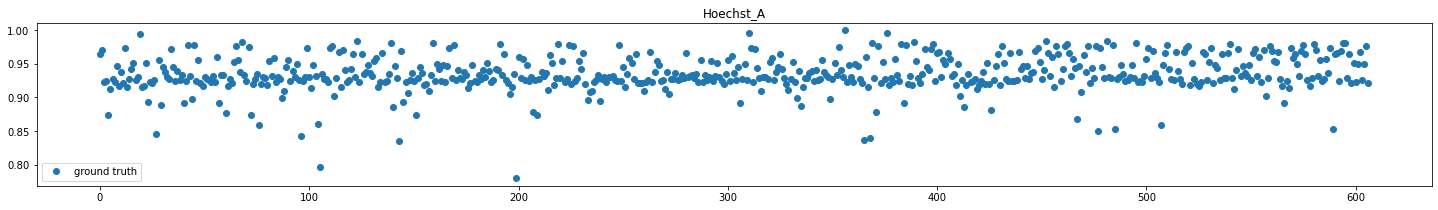

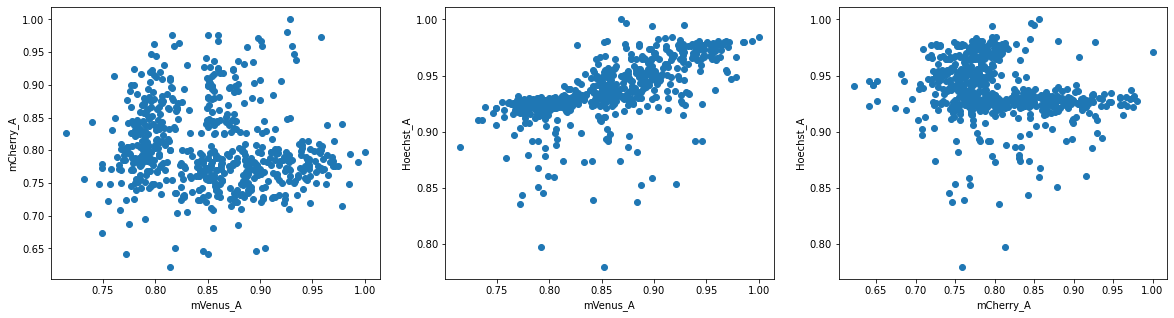

In [7]:
plt.figure(figsize=(25, 3))
plt.title('distance')
plt.plot(distance_targets, 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('cutoff distance')
plt.plot(cutoff_distance_targets, 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(np_targets[:, 0], 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(np_targets[:, 1], 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(np_targets[:, 2], 'o', label='ground truth')
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(np_targets[:, 0], np_targets[:, 1])
plt.xlabel('mVenus_A')
plt.ylabel('mCherry_A')

plt.subplot(1, 3, 2)
plt.scatter(np_targets[:, 0], np_targets[:, 2])
plt.xlabel('mVenus_A')
plt.ylabel('Hoechst_A')

plt.subplot(1, 3, 3)
plt.scatter(np_targets[:, 1], np_targets[:, 2])
plt.xlabel('mCherry_A')
plt.ylabel('Hoechst_A')
plt.show()



In [8]:
print('CCesc2i_Meta size: {}'.format(CCesc2i_Meta.shape))
print('DTesc2i_Meta size: {}'.format(DTesc2i_Meta.shape))
print()
print('CCesc2i_counts size: {}'.format(CCesc2i_counts.shape))
print('DTesc2i_tpm size: {}'.format(DTesc2i_tpm.shape))
print()
print('merged_CCesc2i size: {}'.format(merged_CCesc2i.shape))
print('merged_DTesc2i size: {}'.format(merged_DTesc2i.shape))
print()
print('CCesc2i size: {}'.format(CCesc2i.shape))
print('DTesc2i size: {}'.format(DTesc2i.shape))
print()
print('DTesc2i_UT size: {}'.format(DTesc2i_UT.shape))
print()
print('CCesc2i_DTesc2i_UT size: {}'.format(CCesc2i_DTesc2i_UT.shape))
print('df_total size: {}'.format(df_total.shape))
print()
print('features size: {}'.format(np_features.shape))
print('targets size: {}'.format(np_targets.shape))
print('train set size: {}'.format(len(X_train)))
print('test set size: {}'.format(len(X_test)))
print()


CCesc2i_Meta size: (430, 30)
DTesc2i_Meta size: (541, 21)

CCesc2i_counts size: (485, 49194)
DTesc2i_tpm size: (581, 49194)

merged_CCesc2i size: (430, 49200)
merged_DTesc2i size: (536, 49200)

CCesc2i size: (430, 49197)
DTesc2i size: (536, 49197)

DTesc2i_UT size: (180, 49197)

CCesc2i_DTesc2i_UT size: (610, 49197)
df_total size: (1892, 49197)

features size: (607, 64)
targets size: (607, 3)
train set size: 424
test set size: 183



# Grid Search

search for epsilons
min train loss: 0.00013473506712929342 when epsilon= 2.310129700083158e-05
min test loss: 0.0013568485291920805 when epsilon= 0.014174741629268049



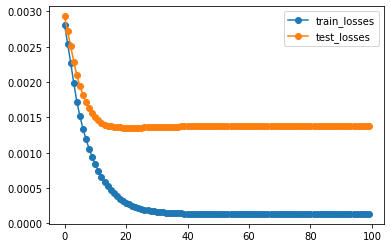

search for gammas
min train loss: 0.00016228227844626775 when gamma= 4.534878508128582
min test loss: 0.00125261418287817 when gamma= 0.00041320124001153346



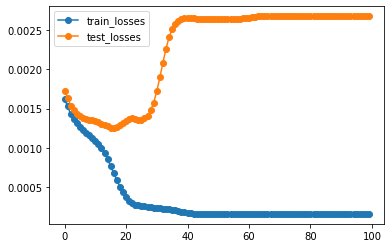

search for Cs
min train loss: 0.0001747103261272729 when C=1000.0
min test loss: 0.001245755691476642 when C=0.8497534359086456



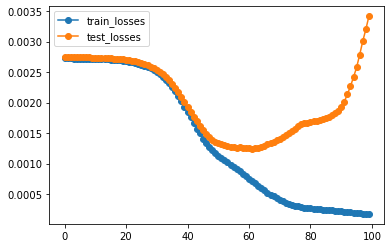

In [9]:
# eps -> gamma -> C

### search epsilons ###

epsilons = np.logspace(-1, -5, 100)

train_losses = []
test_losses = []

for i in range(len(epsilons)):
    svr = SVR(kernel="rbf", epsilon=epsilons[i])
    model = MultiOutputRegressor(svr)
    pred = model.fit(X_train, y_train).predict(X_train)
    train_loss = mean_squared_error(y_train, pred)
    train_losses.append(train_loss)

    pred_test = model.predict(X_test)
    test_loss = mean_squared_error(y_test, pred_test)
    test_losses.append(test_loss)

print('search for epsilons')
print('min train loss: {} when epsilon= {}'.format(np.min(train_losses), epsilons[np.argmin(train_losses)]))
print('min test loss: {} when epsilon= {}'.format(np.min(test_losses), epsilons[np.argmin(test_losses)]))
print()

plt.plot(train_losses, 'o-', label='train_losses')
plt.plot(test_losses, 'o-', label='test_losses')
plt.legend()
plt.show()

best_eps = epsilons[np.argmin(test_losses)]

### end search epsilons ###

### search gammas ###

gammas = np.logspace(-5, 5, 100)

train_losses = []
test_losses = []

for i in range(len(gammas)):
    svr = SVR(kernel="rbf", gamma=gammas[i], epsilon=best_eps)
    model = MultiOutputRegressor(svr)
    pred = model.fit(X_train, y_train).predict(X_train)
    train_losses.append(mean_squared_error(y_train, pred))

    pred_test = model.predict(X_test)
    test_losses.append(mean_squared_error(y_test, pred_test))

print('search for gammas')
print('min train loss: {} when gamma= {}'.format(np.min(train_losses), gammas[np.argmin(train_losses)]))
print('min test loss: {} when gamma= {}'.format(np.min(test_losses), gammas[np.argmin(test_losses)]))
print()

plt.plot(train_losses, 'o-', label='train_losses')
plt.plot(test_losses, 'o-', label='test_losses')
plt.legend()
plt.show()

best_gamma = gammas[np.argmin(test_losses)]

### end gammas ###

### search Cs ###

cs = np.logspace(-5, 3, 100)

train_losses = []
test_losses = []

for i in range(len(cs)):
    svr = SVR(kernel="rbf", C=cs[i], gamma=best_gamma, epsilon=best_eps)
    model = MultiOutputRegressor(svr)
    pred = model.fit(X_train, y_train).predict(X_train)
    train_loss = mean_squared_error(y_train, pred)
    train_losses.append(train_loss)

    pred_test = model.predict(X_test)
    test_loss = mean_squared_error(y_test, pred_test)
    test_losses.append(test_loss)

print('search for Cs')
print('min train loss: {} when C={}'.format(np.min(train_losses), cs[np.argmin(train_losses)]))
print('min test loss: {} when C={}'.format(np.min(test_losses), cs[np.argmin(test_losses)]))
print()

plt.plot(train_losses, 'o-', label='train_losses')
plt.plot(test_losses, 'o-', label='test_losses')
plt.legend()
plt.show()

best_C = cs[np.argmin(test_losses)]

### end search Cs ###

# Plot Best Results

Train Data


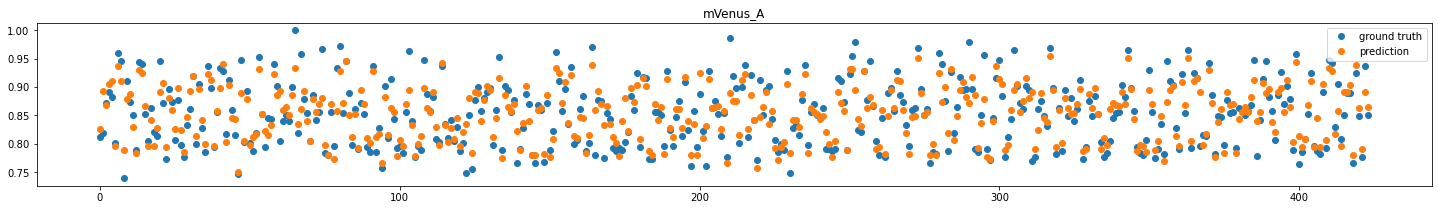

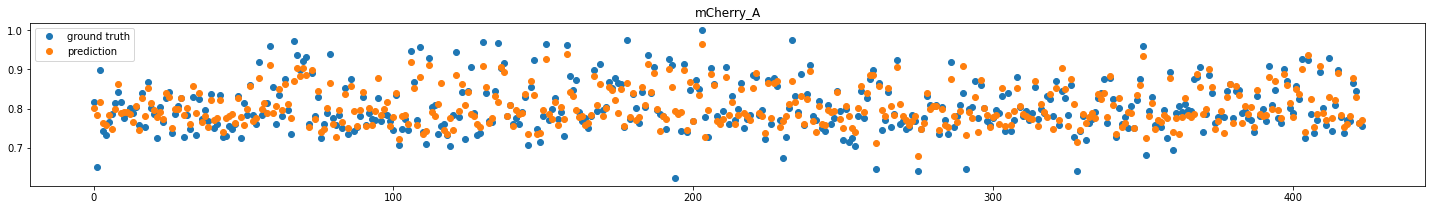

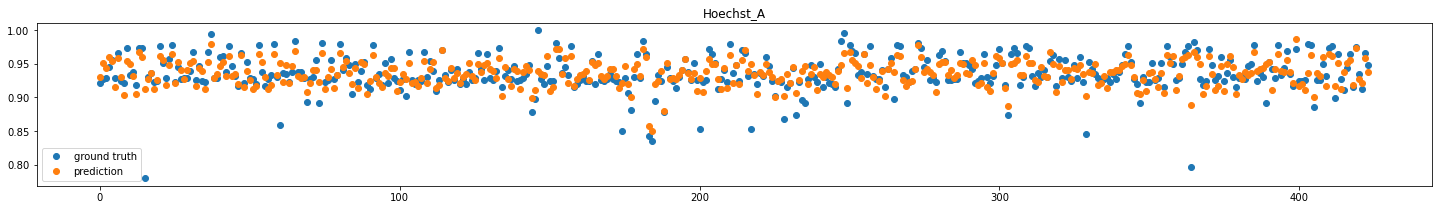


Test Data


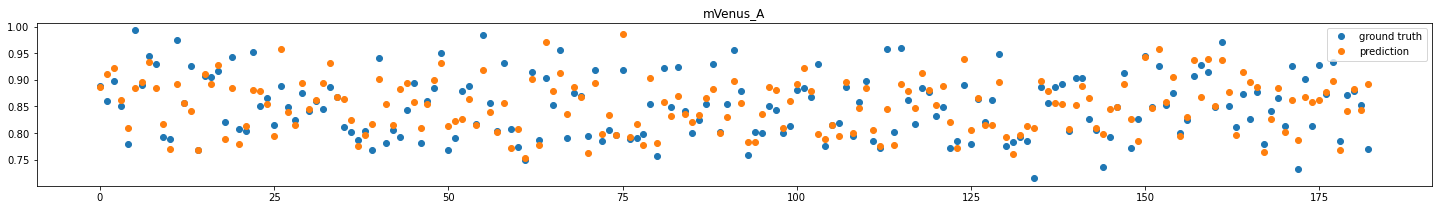

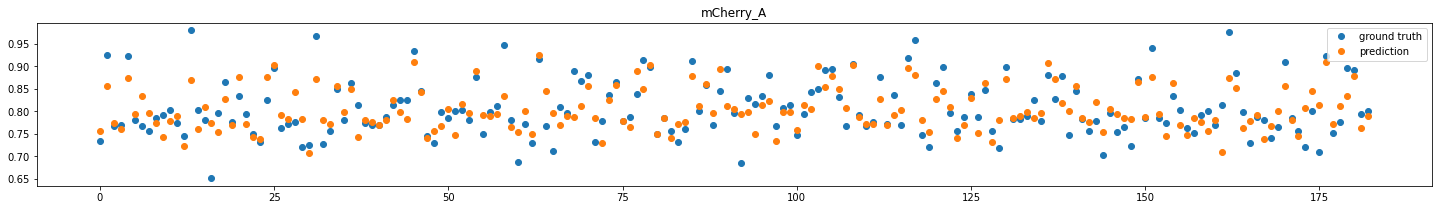

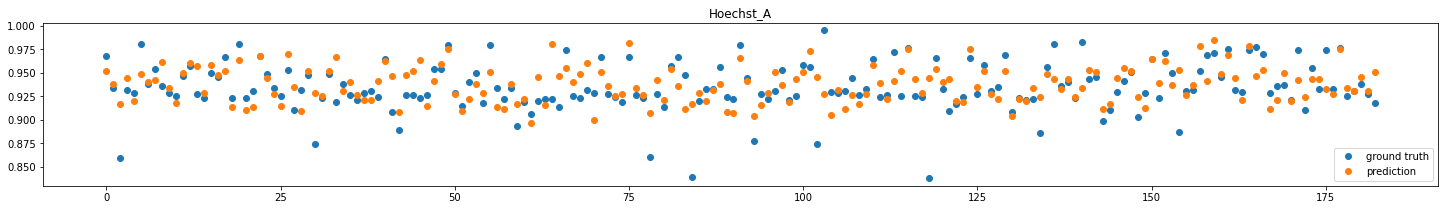

In [10]:
svr = SVR(kernel="rbf", C=best_C, gamma=best_gamma, epsilon=best_eps)
model = MultiOutputRegressor(svr)

pred = model.fit(X_train, y_train).predict(X_train)
train_loss = mean_squared_error(y_train, pred)
    
print("Train Data")

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y_train[:, 0], 'o', label='ground truth')
plt.plot(pred[:, 0], 'o', label='prediction')
plt.legend()
#plt.ylim((0,1))
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y_train[:, 1], 'o', label='ground truth')
plt.plot(pred[:, 1], 'o', label='prediction')
plt.legend()
#plt.ylim((0,1))
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y_train[:, 2], 'o', label='ground truth')
plt.plot(pred[:, 2], 'o', label='prediction')
plt.legend()
#plt.ylim((0,1))
plt.show()

pred_test = model.predict(X_test)
test_loss = mean_squared_error(y_test, pred_test)

print()
print("Test Data")

plt.figure(figsize=(25, 3))
plt.title('mVenus_A')
plt.plot(y_test[:, 0], 'o', label='ground truth')
plt.plot(pred_test[:, 0], 'o', label='prediction')
plt.legend()
#plt.ylim((0,1))
plt.show()

plt.figure(figsize=(25, 3))
plt.title('mCherry_A')
plt.plot(y_test[:, 1], 'o', label='ground truth')
plt.plot(pred_test[:, 1], 'o', label='prediction')
plt.legend()
#plt.ylim((0,1))
plt.show()

plt.figure(figsize=(25, 3))
plt.title('Hoechst_A')
plt.plot(y_test[:, 2], 'o', label='ground truth')
plt.plot(pred_test[:, 2], 'o', label='prediction')
plt.legend()
#plt.ylim((0,1))
plt.show()